In [10]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import time


import numpy as np

from PIL import Image
import os, glob, numpy as np
import pandas as pd
from sklearn import datasets, model_selection
from sklearn.model_selection import train_test_split


USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [11]:
img_dir = './dataset'
categories = ['bad', 'good']
np_classes = len(categories)

X = []
y = []

for idx, cat in enumerate(categories):
    
    img_dir_detail = img_dir + "/" + cat
    files = glob.glob(img_dir_detail+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    
    for i, f in enumerate(files):
        try:
            img = Image.open(f)      #폴더를 열어주고 이미지를 읽음
            img = img.convert("RGB")   #RGB로 바꿈
            resize_img = img.resize((128,128)) #이미지 크기를 모두 학습시키기 쉽게 128x128크기
            
            r, g, b = resize_img.split() # 각 쪼갠 이미지를 255로 나눠서 0~1 사이의 값이 나오도록 정규화한다.
            r_resize_img = np.asarray(np.float32(r) / 255.0)
            b_resize_img = np.asarray(np.float32(g) / 255.0)
            g_resize_img = np.asarray(np.float32(b) / 255.0)
            
            rgb_resize_img = np.asarray([r_resize_img, b_resize_img, g_resize_img]) # 이렇게 가공한 이미지를 추가한다.
            
            X.append(rgb_resize_img)
            y.append(idx) # 라벨 (ant: 0, bee: 1)
            if i % 700 == 0: #700으로 하면 폴더 명과 파일 길이를 더 
                print(cat, " : ", f)
        except:
            print(cat, str(i)+" 번째에서 에러 ")


X = np.array(X, dtype='float32')
y = np.array(y, dtype='int64')

#1 0  이면 bad
#0 1  이면 good

print("ok", len(y))

bad  파일 길이 :  434
bad  :  ./dataset/bad/4f08fc98-7d4d-43f7-921d-b2ccf8ca726d_270.jpg
good  파일 길이 :  1379
good  :  ./dataset/good/7ebb4762-7de4-4754-8cd2-2d4f743f512c_90.jpg
good  :  ./dataset/good/9eaca121-9239-49f4-9d05-34ef9f10bcaa_225.jpg
ok 1813


In [12]:
def train_val_test_split(X, y, train_size, val_size, test_size):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = test_size)
    relative_train_size = train_size / (val_size + train_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      train_size = relative_train_size, test_size = 1-relative_train_size)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [13]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X,y,0.6,0.1,0.3)

In [14]:
X_train = torch.from_numpy(X_train).float()
X_val = torch.from_numpy(X_val).float()
X_test = torch.from_numpy(X_test).float()

y_train = torch.from_numpy(y_train).long()
y_val = torch.from_numpy(y_val).long()
y_test = torch.from_numpy(y_test).long()

In [15]:
#TensorDataset을 DataLoader에 전달해서 데이터의 일부만 간단히 추출
train = TensorDataset(X_train, y_train)
val = TensorDataset(X_val, y_val)
test = TensorDataset(X_test, y_test)

#순서로 섞어서 32개씩 데이터를 변환하는 DataLoader 작성
train_loader = DataLoader(train, batch_size=32, shuffle=True, num_workers = 4)
val_loader = DataLoader(val, batch_size=32, shuffle=False, num_workers = 4)
test_loader = DataLoader(test, batch_size=32, shuffle=False, num_workers = 4)

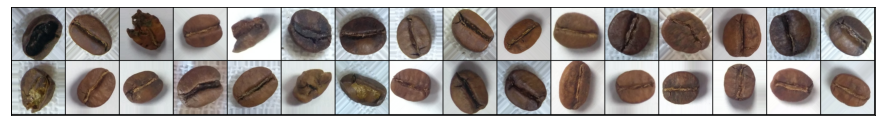

In [16]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,2))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_loader)

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets



# kernel size 5x5, 2 Convolutional layer#
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # 합성곱층
    
    # 채널 수 : 3 / output volume_size : 10(필터의 개수==10개의 특징맵을 생성) / kernel_size(필터의 사이즈) = 5x5
    # kernel size를 하나만 입력하면 NxN으로 간주. / NxM을 원할경우, (N,M)으로 정의
    # 입력 채널 수 : 10 (conv1의 결과물) / output volume size : 20 (20개의 특징맵을 생성) / kernel_size(필터의 사이즈) = 5x5
    self.conv1 = nn.Conv2d(3, 10, 5) # 입력 채널 수, 출력 채널 수, 필터 크기
    self.conv2 = nn.Conv2d(10, 20, 5)
    

    # 전결합층
    self.fc1 = nn.Linear(20 * 29 * 29, 50) # 29=(((((128-5)+1)/2)-5)+1)/2
    
    #dropout적용
    self.dropout1 = nn.Dropout(0.5)
    
    self.fc2 = nn.Linear(50, 2)
    
#CNN Network의 동작(forward)함수, 본격적으로 데이터가 지나갈 길을 닦아준다 생각하면 됨.
  def forward(self, x):
    # 풀링층 : 각 레이어는 conv - pooling - relu를 하나의 묶음으로 간주
    x = F.max_pool2d(F.relu(self.conv1(x)), 2,2) # max pooling with (2x2)kernel
    x = F.max_pool2d(F.relu(self.conv2(x)), 2,2)
    
    # 데이터를 FC레이어에 넣기 위해 2차원에서 1차원 형태로 변경
    x = x.view(-1, 20 * 29 * 29)
    
    #RELU activation function+Dropout
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    
     # 출력 클래스 10개인 Output생성
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

# 인스턴스 생성
model = Net()#.to(DEVICE)

batch_size = 64
num_epoch = 5000

In [22]:
import torch
import torchvision
import torchsummary
model = Net().to(DEVICE)
print(model)

Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=16820, out_features=50, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)


In [23]:
from torchsummary import summary
summary(model, input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 124, 124]             760
            Conv2d-2           [-1, 20, 58, 58]           5,020
            Linear-3                   [-1, 50]         841,050
           Dropout-4                   [-1, 50]               0
            Linear-5                    [-1, 2]             102
Total params: 846,932
Trainable params: 846,932
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 1.69
Params size (MB): 3.23
Estimated Total Size (MB): 5.11
----------------------------------------------------------------


In [24]:
'''
train이 val보다 높으면 과적합
과적합 찾아보기
'''

'\ntrain이 val보다 높으면 과적합\n과적합 찾아보기\n'

In [ ]:
# https://hoya012.github.io/blog/DenseNet-Tutorial-2/
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

start_time = time.time()

total = 0
correct = 0
running_loss_history = []
running_correct_history = []
validation_running_loss_history = []
validation_running_correct_history = []


for epoch in range(num_epoch):  
    epoch = epoch+1
    total = 0
    running_correct = 0.0
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        X_train, y_train = data
        X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() #손실이 갖고 있는 스칼라 값을 가져올 수 있습니다.
       
        _, predicted = torch.max(outputs.data, 1)
        total += y_train.size(0)
        running_correct += (predicted == y_train).sum().item()
       # a = torch.tensor(torch.sum(predicted == y_train).item() / len(predicted))
    
    
    # validation part
    val_total = 0
    validation_running_loss = 0.0
    validation_running_correct = 0.0
    
    for i, data in enumerate(val_loader, 0):
        X_val, y_val = data
        X_val, y_val = X_val.to(DEVICE), y_val.to(DEVICE)
        outputs = model(X_val)
        
        val_loss = criterion(outputs, y_val) 
        validation_running_loss += val_loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        val_total += y_val.size(0)
        validation_running_correct += (predicted == y_val).sum().item()
        
        
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_correct / len(train_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_correct_history.append(epoch_acc)

    val_epoch_loss = validation_running_loss / len(val_loader.dataset)
    val_epoch_acc = validation_running_correct / len(val_loader.dataset)
    validation_running_loss_history.append(val_epoch_loss)
    validation_running_correct_history.append(val_epoch_acc)
    
    total_time = time.time() - start_time
    print(epoch,"epoch")
    print("training loss: {:.5f}, acc: {:5f}".format(epoch_loss, epoch_acc*100))
    print("validation loss: {:.5f}, acc: {:5f}".format(val_epoch_loss, val_epoch_acc*100))
    
    print('---------------------------------------------------------------------') 

print('Finished Training')

In [83]:
def plot_acc(train_losses, valid_losses):
    '''
    training과 validation loss를 시각화하는 함수
    '''
    
    # plot style을 seaborn으로 설정
    plt.style.use('seaborn')
    
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training acc') 
    ax.plot(valid_losses, color='red', label='Validation acc')
    ax.set(title="Acc over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # plot style을 기본값으로 설정
    plt.style.use('default')

In [84]:
def plot_loss(train_losses, valid_losses):
    '''
    training과 validation loss를 시각화하는 함수
    '''
    
    # plot style을 seaborn으로 설정
    plt.style.use('seaborn')

    train_losses = list(np.array(train_losses))
    valid_losses = list(np.array(valid_losses))

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # plot style을 기본값으로 설정
    plt.style.use('default')

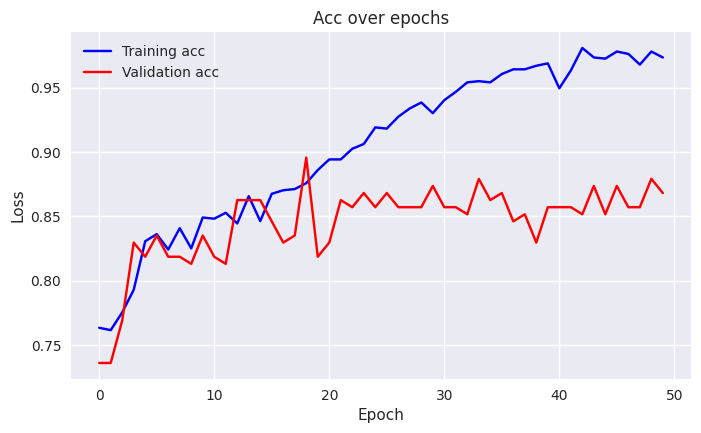

In [85]:
plot_acc(running_correct_history, validation_running_correct_history)

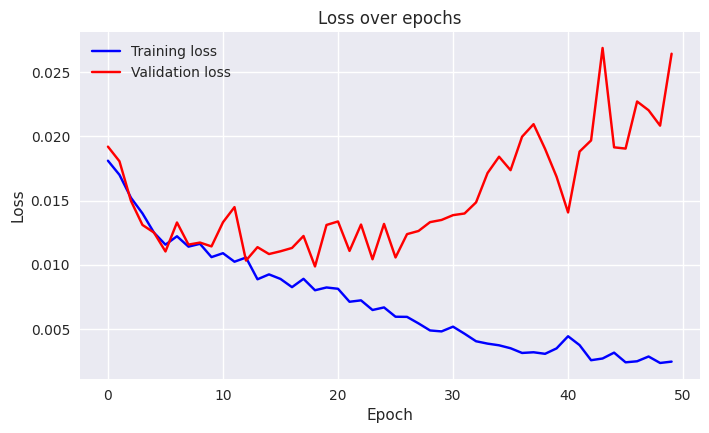

In [86]:
plot_loss(running_loss_history, validation_running_loss_history)

In [75]:
print(type(validation_running_correct.to('cpu').numpy()))

<class 'numpy.ndarray'>


In [83]:
print(type(val_epoch_acc.to('cpu').numpy()))

<class 'numpy.ndarray'>


In [82]:
print(type(epoch_acc.to('cpu').numpy()))

<class 'numpy.ndarray'>


In [84]:
t1 = val_epoch_acc.to('cpu').numpy()
v1 = epoch_acc.to('cpu').numpy()




In [85]:
l = []

In [88]:
l.append(v1)

In [89]:
l

[array(27.833334, dtype=float32), array(0.99908, dtype=float32)]

In [91]:
why = np.array(l)
why

array([27.833334,  0.99908 ], dtype=float32)

In [92]:
list(why)

[27.833334, 0.99908]

In [69]:
running_loss_history

[0.0016023716017545613,
 0.0004927406167626902,
 0.0006264729328039501,
 0.0005710894017318168,
 0.0017007934813119518,
 0.00130248502524023,
 0.0006135293837763513,
 0.0005249924544729515,
 0.0005644718403546714,
 0.0006450950511489006,
 0.00046916596845615735,
 0.0007588767127211873,
 0.0009124561096434486,
 0.0007581826247593598,
 0.0004219817331364068,
 0.0004899656285650483,
 0.00045848992891376624,
 0.000468402883291104,
 0.0003743218123883252,
 0.0003222083856245968,
 0.00036373213517625037,
 0.0004987937691488681,
 0.0020358403467786563,
 0.002322491175092494,
 0.0014681840284831184,
 0.0011351449865862392,
 0.0004342189676615837,
 0.0010398749546760482,
 0.00048188518996460995,
 0.00041006042240440276,
 0.0003839477120445426,
 0.00034878944781647006,
 0.0006029980082637626,
 0.0004921977093041444,
 0.0018553096126754732,
 0.0005670133999414123,
 0.0005505893143680704,
 0.000336423689932601,
 0.00031907655096402105,
 0.00027104521283460907,
 0.00037411183208702027,
 0.000159787

In [70]:
running_correct_history

[tensor(0.9844, device='cuda:0'),
 tensor(1., device='cuda:0'),
 tensor(0.9963, device='cuda:0'),
 tensor(0.9963, device='cuda:0'),
 tensor(0.9853, device='cuda:0'),
 tensor(0.9880, device='cuda:0'),
 tensor(0.9963, device='cuda:0'),
 tensor(0.9982, device='cuda:0'),
 tensor(0.9963, device='cuda:0'),
 tensor(0.9945, device='cuda:0'),
 tensor(0.9982, device='cuda:0'),
 tensor(0.9926, device='cuda:0'),
 tensor(0.9936, device='cuda:0'),
 tensor(0.9972, device='cuda:0'),
 tensor(0.9991, device='cuda:0'),
 tensor(0.9982, device='cuda:0'),
 tensor(0.9963, device='cuda:0'),
 tensor(0.9982, device='cuda:0'),
 tensor(0.9991, device='cuda:0'),
 tensor(0.9982, device='cuda:0'),
 tensor(0.9991, device='cuda:0'),
 tensor(0.9963, device='cuda:0'),
 tensor(0.9733, device='cuda:0'),
 tensor(0.9761, device='cuda:0'),
 tensor(0.9844, device='cuda:0'),
 tensor(0.9890, device='cuda:0'),
 tensor(0.9991, device='cuda:0'),
 tensor(0.9871, device='cuda:0'),
 tensor(0.9963, device='cuda:0'),
 tensor(0.9954, de

In [58]:
print(type(torch.unbind(torch.tensor(a))))

<class 'tuple'>


In [56]:
np.array(a)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [21]:
a = running_correct_history

In [51]:
np.array(a)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [25]:
print(type(a)) learn.py  #EP000

<class 'list'>


In [49]:
a.numpy()

AttributeError: 'list' object has no attribute 'numpy'

In [45]:
import matplotlib.pyplot as plt
plt.plot(running_correct_history.cpu().numpy())

AttributeError: 'list' object has no attribute 'cpu'

In [ ]:
plt.plot(running_correct_history,label='Training Loss')
plt.plot(validation_running_correct_history, label='test/validation loss')
plt.legend()

In [ ]:
running_loss_history = []
running_correct_history = []
validation_running_loss_history = []
validation_running_correct_history = []

for e in range(num_epoch):

  running_loss = 0.0
  running_correct = 0.0
  validation_running_loss = 0.0
  validation_running_correct = 0.0

  for inputs, labels in train_loader:

    inputs = X_train.to(DEVICE)
    labels = y_train.to(DEVICE)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)

    running_correct += torch.sum(preds == labels.data)
    running_loss += loss.item()



  else:
    # 훈련팔 필요가 없으므로 메모리 절약
    with torch.no_grad():

      for val_input, val_label in val_loader:

        val_input = X_val.to(DEVICE)
        val_label = y_val.to(DEVICE)
        val_outputs = model(val_input)
        val_loss = criterion(val_outputs, val_label)

        _, val_preds = torch.max(val_outputs, 1)
        validation_running_loss += val_loss.item()
        validation_running_correct += torch.sum(val_preds == val_label.data)


    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_correct.float() / len(train_loader)
    running_loss_history.append(epoch_loss)
    running_correct_history.append(epoch_acc)

    val_epoch_loss = validation_running_loss / len(val_loader)
    val_epoch_acc = validation_running_correct.float() / len(val_loader)
    validation_running_loss_history.append(val_epoch_loss)
    validation_running_correct_history.append(val_epoch_acc)

    print("===================================================")
    print("epoch: ", e + 1)
    print("training loss: {:.5f}, acc: {:5f}".format(epoch_loss, epoch_acc))
    print("validation loss: {:.5f}, acc: {:5f}".format(val_epoch_loss, val_epoch_acc))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for epoch in range(num_epoch): 

    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for data in test_loader:
            X_test, y_test = data
            X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)
            outputs = model(X_test)
            
            
            test_loss += F.cross_entropy(outputs, y_test, reduction='sum').item()
            
            _, predicted = torch.max(outputs, 1)
            c = (predicted == y_test).squeeze()
            
            for i in range(y_test.shape[0]):
                label = y_test[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            
                total += y_test.size(0)
                correct += (predicted == y_test).sum().item()
                
            
        test_loss /= len(test_loader.dataset)
        print('[%d epoch] Test Accuracy: %d %%' % (epoch + 1, 100 * correct / total),', Loss:{:.4f}'.format(test_loss))
                      

   
print('Accuracy of the network on the 1813 test images: %d %%' % (
    100 * correct / total)) 

for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        categories[i], 100 * class_correct[i] / class_total[i])) 


In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
for epoch in range(num_epoch):  
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))